### **Differential Scorecards**

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# datasets
from sklearn.datasets import load_iris
from ucimlrepo import fetch_ucirepo 
from io import StringIO

# discretization
from libraries.caimcaim import CAIMD # https://github.com/airysen/caimcaim/blob/master/caimcaim/caimcaim.py

# grid search
from sklearn.model_selection import GridSearchCV

# objective function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import torch

# evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

##### datasets

**iris**:

In [50]:
iris_data = load_iris()
iris_X = pd.DataFrame(iris_data.data)
iris_y = pd.DataFrame(iris_data.target)

print("num observations: ", iris_y.count())
print("num features: ", iris_X.count())
print("target distribution: ", iris_y.value_counts())

num observations:  0    150
dtype: int64
num features:  0    150
1    150
2    150
3    150
dtype: int64
target distribution:  0    50
1    50
2    50
Name: count, dtype: int64


**adult**: predict whether annual income of an individual exceeds $50K/yr based on census data. 

https://archive.ics.uci.edu/dataset/2/adult

num observations:  income    32561
dtype: int64
num features:  14
target distribution:  income
0.0       24720
1.0        7841
Name: count, dtype: int64


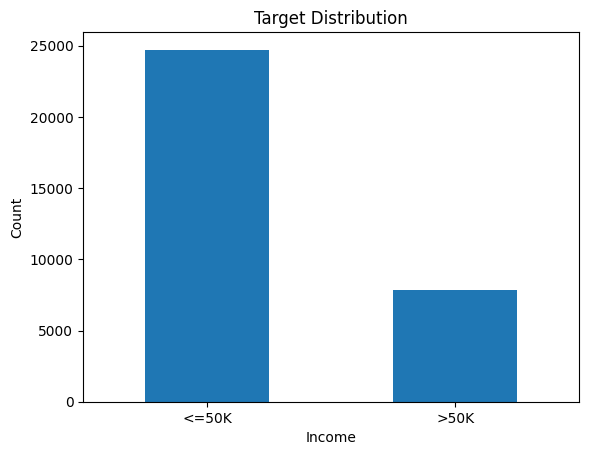

In [51]:
# fetch dataset 
adult_data = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
adult_X = adult_data.data.features 
adult_y = adult_data.data.targets
adult_y.loc[:,'income'] = adult_y['income'].map({'>50K': 1, '<=50K': 0})
  
# metadata 
# print(adult_data.metadata) 
  
# variable information 
# print(adult_data.variables) 

print("num observations: ", adult_y.count())
print("num features: ", adult_X.shape[1])
print("target distribution: ", adult_y.value_counts())
adult_y['income'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks([0, 1], ['<=50K', '>50K'], rotation=0)
plt.show()

**mammo**: discrimination of benign and malignant mammographic masses based on BI-RADS attributes and the patient's age.

https://archive.ics.uci.edu/dataset/161/mammographic+mass

num rows with nulls:  162
num observations:  830
num features:  5
target distribution:  Severity
0    427
1    403
Name: count, dtype: int64


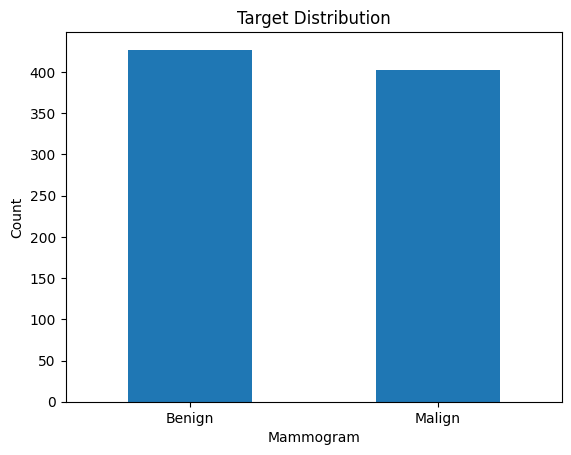

In [52]:
# fetch dataset 
mammo_data = fetch_ucirepo(id=161) 
  
# data (as pandas dataframes) 
mammo_X = mammo_data.data.features 
mammo_y = mammo_data.data.targets 

# drop rows with nulls
mammo_combined = pd.concat([mammo_X, mammo_y], axis=1)
print("num rows with nulls: ", mammo_combined.isnull().sum().sum())
mammo_combined = mammo_combined.dropna()
mammo_combined = mammo_combined.reset_index(drop=True)
mammo_X = mammo_combined.iloc[:, :-1]
mammo_y = mammo_combined.iloc[:, -1]


# metadata 
# print(mammo_data.metadata) 
  
# variable information 
# print(mammo_data.variables) 

print("num observations: ", mammo_y.count())
print("num features: ", mammo_X.shape[1])
print("target distribution: ", mammo_y.value_counts())
# show target distribution
mammo_y.value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Mammogram')
plt.ylabel('Count')
plt.xticks([0, 1], ['Benign', 'Malign'], rotation=0)
plt.show()

**mushroom**: mushrooms described in terms of physical characteristics; classification: poisonous or edible.

https://archive.ics.uci.edu/dataset/73/mushroom

num observations:  poisonous    8124
dtype: int64
num features:  22
target distribution:  poisonous
0            4208
1            3916
Name: count, dtype: int64


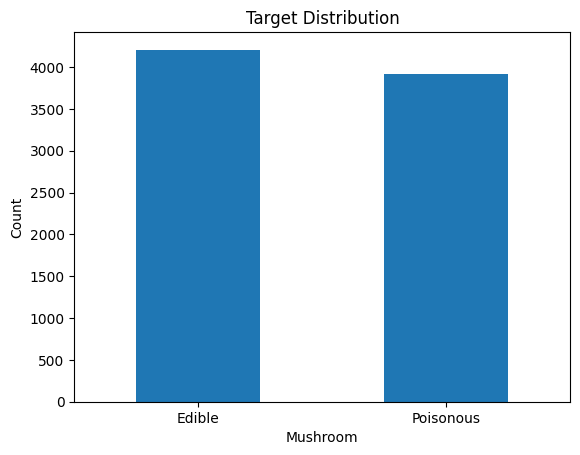

In [53]:
# fetch dataset 
mushroom_data = fetch_ucirepo(id=73) 

# data (as pandas dataframes) 
mushroom_X = mushroom_data.data.features 
mushroom_y = mushroom_data.data.targets 
mushroom_y.loc[:, 'poisonous'] = mushroom_y['poisonous'].map({'p': 1, 'e': 0})
  
# metadata 
# print(mushroom_data.metadata) 
  
# variable information 
# print(mushroom_data.variables) 

print("num observations: ", mushroom_y.count())
print("num features: ", mushroom_X.shape[1])
print("target distribution: ", mushroom_y.value_counts())
# show target distribution
mushroom_y['poisonous'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Mushroom')
plt.ylabel('Count')
plt.xticks([0, 1], ['Edible', 'Poisonous'], rotation=0)
plt.show()

**spambase**: classifying Email as Spam or Non-Spam.

https://archive.ics.uci.edu/dataset/94/spambase

num observations:  Class    4601
dtype: int64
num features:  57
target distribution:  Class
0        2788
1        1813
Name: count, dtype: int64


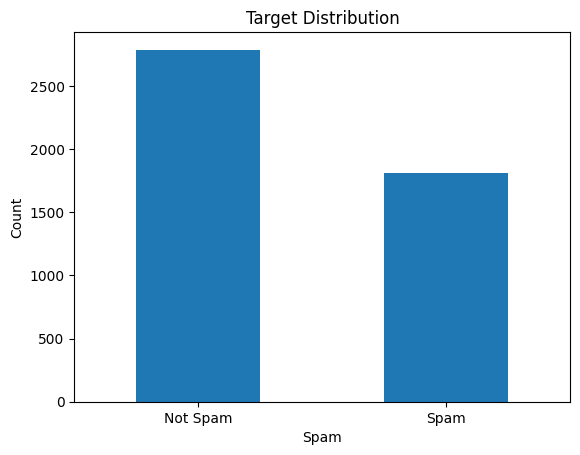

In [54]:
# fetch dataset 
spambase_data = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
spambase_X = spambase_data.data.features 
spambase_y = spambase_data.data.targets 
  
# metadata 
# print(spambase_data.metadata) 
  
# variable information 
# print(spambase_data.variables) 

print("num observations: ", spambase_y.count())
print("num features: ", spambase_X.shape[1])
print("target distribution: ", spambase_y.value_counts())
# show target distribution
spambase_y['Class'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Spam')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Spam', 'Spam'], rotation=0)
plt.show()

**telemarketing**: set of possible advertisements on Internet pages

num observations:  3278
num features:  1558
target distribution:  ad.
0    2820
1     458
Name: count, dtype: int64


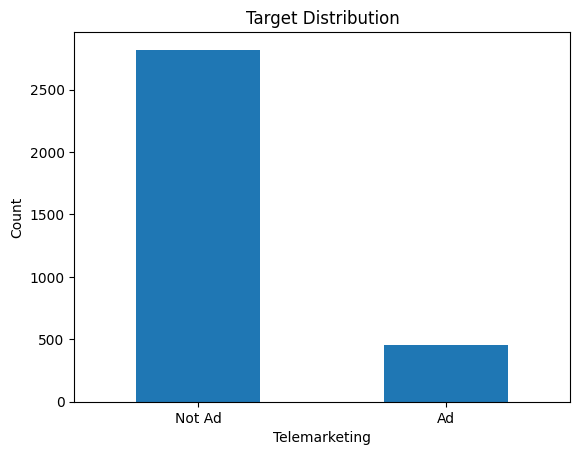

In [55]:
# load dataset from file. target is last column
telemarketing_data = pd.read_csv('datasets/internet+advertisements/ad.data', dtype=str)
telemarketing_X = telemarketing_data.iloc[:, :-1]
telemarketing_y = telemarketing_data.iloc[:, -1]

telemarketing_y = telemarketing_y.map({'nonad.': 0, 'ad.': 1})

print("num observations: ", telemarketing_y.count())
print("num features: ", telemarketing_X.shape[1])
print("target distribution: ", telemarketing_y.value_counts())
# show target distribution
telemarketing_y.value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Telemarketing')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Ad', 'Ad'], rotation=0)
plt.show()

**sleep apnea**: collection of clinical polysomnography (PSG) recordings. Beginning with PSG recordings from from ~19K patients evaluated at the Massachusetts General Hospital.

https://bdsp.io/content/hsp/2.0/#files

In [56]:
sleep_apnea_data = pd.read_csv('datasets/bdsp_psg_master_20231101.csv')

sleep_apnea_X = sleep_apnea_data.iloc[:, :-1]
sleep_apnea_y = sleep_apnea_data.iloc[:, -1]

print("num observations: ", sleep_apnea_y.count())
print("num features: ", sleep_apnea_X.shape[1])

num observations:  26200
num features:  11


**appendicitis**: 7 medical measures taken over 106 patients on which the class label represents if the patient has appendicitis (class label 1) or not (class label 0).

https://sci2s.ugr.es/keel/dataset.php?cod=183#sub2

num observations:  106
num features:  7
target distribution:  Class
0    85
1    21
Name: count, dtype: int64


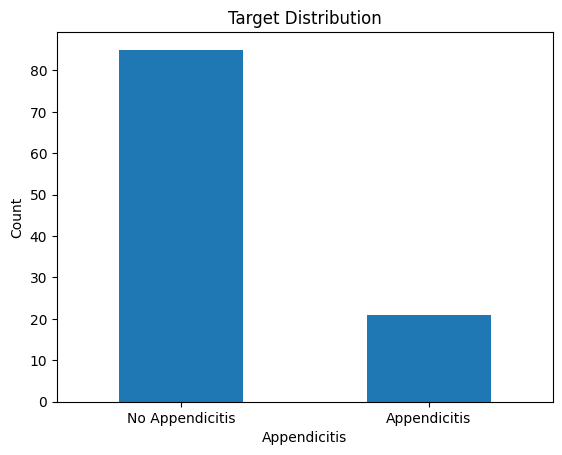

In [57]:
with open('datasets/appendicitis.dat', "r") as file:
    lines = file.readlines()

data_start_ind = lines.index("@data\n") + 1
app_data = lines[data_start_ind:]
app_data = pd.read_csv(StringIO("".join(app_data)), header=None)

app_data.columns = ["At1", "At2", "At3", "At4", "At5", "At6", "At7", "Class"]

app_X = app_data.iloc[:, :-1]
app_y = app_data.iloc[:, -1]

print("num observations: ", app_y.count())
print("num features: ", app_X.shape[1])
print("target distribution: ", app_y.value_counts())
# show target distribution
app_y.value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.xlabel('Appendicitis')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Appendicitis', 'Appendicitis'], rotation=0)
plt.show()

aesthetic evaluation

In [58]:
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation', 'sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

aesthetic_evaluation_data.head()

,Subjective Evaluation,BRA Value,LBC Value,UNR Value,BCE Value,BCD Value,BAD Value,BOD Value,pBRA Value,pLBC Value,...,pBAD Value,pBOD Value,cX2L Value,cX2a Value,cX2b Value,cX2Lab Value,cEMDL Value,cEMDa Value,cEMDb Value,cEMDLab Value
0,Good,1.149009,0.830915,0.107618,0.938534,1.934477,4.885198,17.296370,0.049401,0.033356,...,0.029188,0.103340,0.097502,0.009506,0.217169,0.100670,1.503086,0.030362,0.291363,0.210082
1,Good,2.368824,1.326447,1.599444,0.272997,0.035378,19.932998,68.761479,0.113919,0.058509,...,0.117875,0.406627,0.305692,0.159653,0.193317,0.061736,1.248600,0.206529,0.351693,0.105346
2,Good,1.409939,0.950935,0.278358,1.229293,2.221074,22.277770,38.323430,0.067231,0.038613,...,0.120132,0.206658,0.109386,0.024217,0.280625,0.012974,0.545858,0.075520,0.304185,0.049345
3,Good,2.059918,0.720926,1.786307,1.065381,1.995007,25.163410,31.631070,0.100705,0.032141,...,0.156030,0.196133,0.038581,0.032267,0.026153,0.010779,0.334111,0.105626,0.137693,0.031455
4,Good,2.452595,0.798596,1.868745,1.070148,1.218189,0.395585,31.426783,0.117249,0.035235,...,0.002820,0.224062,0.021259,0.027071,0.029206,0.006495,0.165401,0.081549,0.091768,0.030546


In [59]:
print("num observations: ", aesthetic_evaluation_y.count())
print("num features: ", aesthetic_evaluation_X.shape[1])
print("target distribution: ", aesthetic_evaluation_y.value_counts())

num observations:  1358
num features:  22
target distribution:  Subjective Evaluation
Good         595
Fair         353
Excellent    308
Poor         102
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Subjective Evaluation')

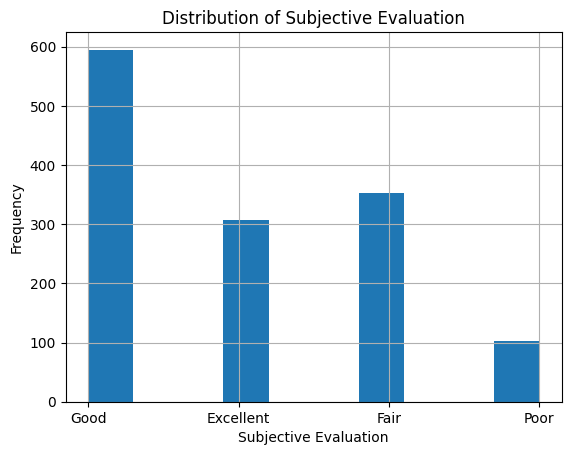

In [60]:
aesthetic_evaluation_y.hist()
plt.xlabel('Subjective Evaluation')
plt.ylabel('Frequency')
plt.title('Distribution of Subjective Evaluation')

target distribution - binary version:  Subjective Evaluation
1    903
0    455
Name: count, dtype: int64


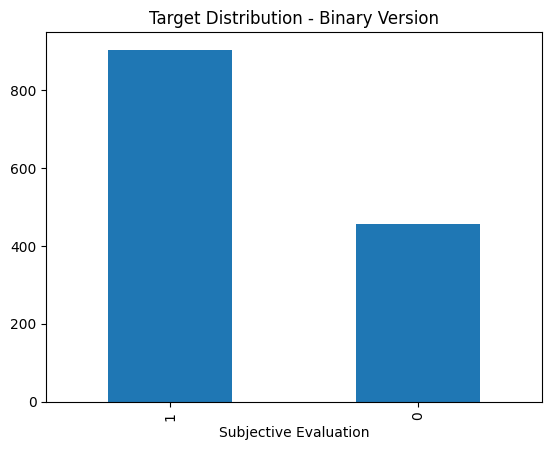

In [61]:
# create binary target from aesthetic evaluation, by joining good and excellent, and fair and poor
aesthetic_evaluation_binary_y = aesthetic_evaluation_y.map({'Excellent': 1, 'Good': 1, 'Fair': 0, 'Poor': 0})

# distribution
print("target distribution - binary version: ", aesthetic_evaluation_binary_y.value_counts())
# show target distribution
aesthetic_evaluation_binary_y.value_counts().plot(kind='bar')
plt.title('Target Distribution - Binary Version')
plt.show()

num observations:  class    1728
dtype: int64
num features:  6
target distribution:  class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


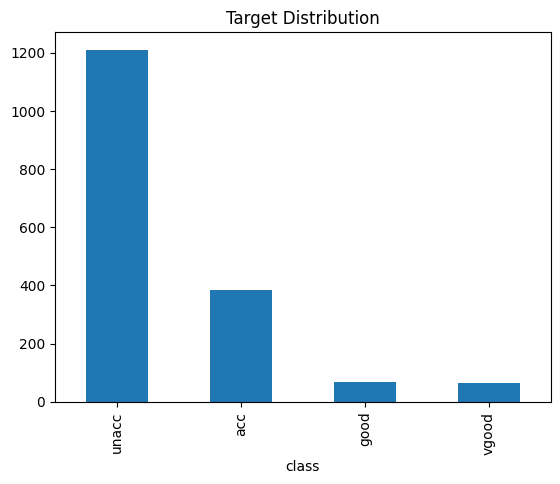

In [62]:
# fetch dataset 
car_evaluation_data = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
car_evaluation_X = car_evaluation_data.data.features 
car__evaluation_y = car_evaluation_data.data.targets 
  
# metadata 
# print(car_evaluation_data.metadata) 
  
# variable information 
# print(car_evaluation_data.variables) 

print("num observations: ", car__evaluation_y.count())
print("num features: ", car_evaluation_X.shape[1])
print("target distribution: ", car__evaluation_y.value_counts())
# show target distribution
car__evaluation_y['class'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.show()

#### discretization thresholds

CAIM

In [63]:
# discretize using CAIM
def discretize_caim_df(data, X, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    
    print("\nCut-off points: ", caim.split_scheme)
    print("Number of bins: ", end="")
    for i, (key, value) in enumerate(caim.split_scheme.items()):
        if i == len(caim.split_scheme) - 1:
            print(f" {key}: {len(value)+1}", end="")
        else:
            print(f" {key}: {len(value)+1}", end=",")
    print()
    
    X_disc_caim = pd.DataFrame(X_disc_caim, columns=X.columns).astype(int) # convert to pandas dataframe and int
        
    return X_disc_caim

''' 
prints of fit() method: Categorical list_of_(indicies)_categorical_features
    # feature_index  GLOBAL CAIM  best_caim_value 
in the returning dataframe:\
    - columns represent the original features
    - rows represent each instance
    - values are the bin number each instance belongs to (starting from 0)
'''

def discretize_caim(X, cols, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    # get thresholds from caim.split_scheme (dict with column index : thresholds)
    # transform all values to floats
    # and keys with column indexes to column names
    thresholds = {cols[i]: [float(val) for val in value] for i, (key, value) in enumerate(caim.split_scheme.items())}
    return thresholds


In [64]:
app_thresholds_caim = discretize_caim(app_X, app_X.columns, app_y)
print("\nthresholds ", app_thresholds_caim)

print("num of bins: ")
for i, (key, value) in enumerate(app_thresholds_caim.items()):
        print(f"  {key}: {len(value)+1}")

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4


infinitesimal bins

In [65]:
# discretize using infinitesimal bins:
# thresholds are the points in between 2 consecutive values in the sorted list

def discretize_infbins(X, cols, y):
    infbins_thresholds = {}
    for col in cols:
        # sort unique values
        sorted_col = np.unique(X[col])
        # get thresholds
        thresholds = (sorted_col[:-1] + sorted_col[1:]) / 2
        infbins_thresholds[col] = thresholds.tolist()

    return infbins_thresholds

In [66]:
app_thresholds_infbins = discretize_infbins(app_X, app_X.columns, app_y)
print("thresholds ", app_thresholds_infbins)
print("num of bins: ")
for i, (key, value) in enumerate(app_thresholds_infbins.items()):
        print(f"  {key}: {len(value)+1}")

thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 0

#### discretized version

num of columns in the new df = (num thresholds + 1) * num features = num bins * num features

2 methods
- 1 out of k: 1 if the value is in the bin, 0 otherwise
- differential coding: 1 from bin 1 until bin where the value is in, 0 otherwise

In [67]:
def get_bins(thresholds, values):
    bins = np.digitize(values, thresholds)
    return bins
    # list of bin number for each row


def disc_1_out_of_k(X, cols, thresholds):
    disc_df = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        bins_df = pd.get_dummies(bins, prefix=f'feat{col}-bin', prefix_sep='').astype(int) # one hot encoding
        for i in range(1, len(thresholds[col]) + 1):
            if f'feat{col}-bin{i}' not in bins_df.columns:
                bins_df[f'feat{col}-bin{i}'] = 0
        bins_df = bins_df.drop(columns=f'feat{col}-bin0', errors='ignore')
        disc_df.append(bins_df)    
    return pd.concat(disc_df, axis=1)


def disc_diff_coding(X, cols, thresholds):
    bin_dfs = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        num_bins = len(thresholds[col]) + 1
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bins >= i).astype(int)
        bin_dfs.append(bin_df)
    return pd.concat(bin_dfs, axis=1)


In [68]:
app_X_disc_caim_1outofk = disc_1_out_of_k(app_X, app_X.columns, app_thresholds_caim)
disc_app_X = app_X_disc_caim_1outofk
app_X_disc_caim_1outofk.head()

,featAt1-bin1,featAt1-bin2,featAt1-bin3,featAt2-bin1,featAt2-bin2,featAt2-bin3,featAt3-bin1,featAt3-bin2,featAt3-bin3,featAt4-bin1,...,featAt4-bin3,featAt5-bin1,featAt5-bin2,featAt5-bin3,featAt6-bin1,featAt6-bin2,featAt6-bin3,featAt7-bin1,featAt7-bin2,featAt7-bin3
0,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
2,1,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,1,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,0
4,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0


In [69]:
app_X_disc_caim_diffcod = disc_diff_coding(app_X, app_X.columns, app_thresholds_caim)
app_X_disc_caim_diffcod.head()

,featAt1-bin1,featAt1-bin2,featAt1-bin3,featAt2-bin1,featAt2-bin2,featAt2-bin3,featAt3-bin1,featAt3-bin2,featAt3-bin3,featAt4-bin1,...,featAt4-bin3,featAt5-bin1,featAt5-bin2,featAt5-bin3,featAt6-bin1,featAt6-bin2,featAt6-bin3,featAt7-bin1,featAt7-bin2,featAt7-bin3
0,1,1,0,1,1,0,1,1,0,1,...,0,1,0,0,1,1,0,1,1,0
1,1,1,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0
2,1,0,0,1,1,0,1,0,0,1,...,0,1,0,0,1,1,0,1,0,0
3,1,0,0,1,0,0,1,0,0,1,...,0,1,1,0,1,0,0,1,0,0
4,1,1,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0


In [70]:
app_X_disc_infbins_1outofk = disc_1_out_of_k(app_X, app_X.columns, app_thresholds_infbins)
app_X_disc_infbins_1outofk.head()

,featAt1-bin1,featAt1-bin2,featAt1-bin3,featAt1-bin4,featAt1-bin5,featAt1-bin6,featAt1-bin7,featAt1-bin8,featAt1-bin9,featAt1-bin10,...,featAt7-bin89,featAt7-bin90,featAt7-bin91,featAt7-bin92,featAt7-bin93,featAt7-bin94,featAt7-bin95,featAt7-bin96,featAt7-bin97,featAt7-bin98
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
app_X_disc_infbins_diffcod = disc_diff_coding(app_X, app_X.columns, app_thresholds_infbins)
app_X_disc_infbins_diffcod.head()

,featAt1-bin1,featAt1-bin2,featAt1-bin3,featAt1-bin4,featAt1-bin5,featAt1-bin6,featAt1-bin7,featAt1-bin8,featAt1-bin9,featAt1-bin10,...,featAt7-bin89,featAt7-bin90,featAt7-bin91,featAt7-bin92,featAt7-bin93,featAt7-bin94,featAt7-bin95,featAt7-bin96,featAt7-bin97,featAt7-bin98
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


#### grid search

In [72]:
def grid_search(model, X, y, param_grid, cv=10):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)
    return grid_search

#### objective function

In [73]:
def get_weights(model, disc_X, y):
    model.fit(disc_X, y)
    weights = model.coef_[0]
    feature_names = disc_X.columns
    weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
    return weights_df

Class
0    85
1    21
Name: count, dtype: int64
RSS best parameters:  {'alpha': 0.001}
RSS weights:
          Feature    Weight
0   featAt1-bin1  0.352374
1   featAt1-bin2  0.352374
2   featAt1-bin3  0.352374
3   featAt2-bin1  0.352374
4   featAt2-bin2  0.352374
5   featAt2-bin3  0.352374
6   featAt3-bin1  0.352374
7   featAt3-bin2  0.352374
8   featAt3-bin3  0.352374
9   featAt4-bin1  0.352374
10  featAt4-bin2  0.352374
11  featAt4-bin3  0.352374
12  featAt5-bin1  0.352374
13  featAt5-bin2  0.352374
14  featAt5-bin3  0.352374
15  featAt6-bin1  0.352374
16  featAt6-bin2  0.352374
17  featAt6-bin3  0.352374
18  featAt7-bin1  0.352374
19  featAt7-bin2  0.352374
20  featAt7-bin3  0.352374


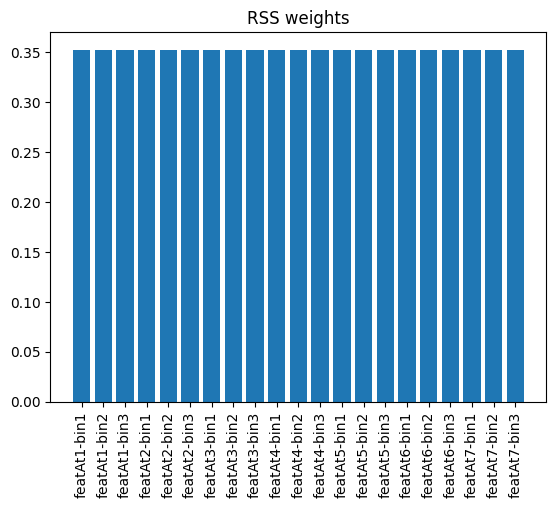

In [74]:
# RSS

def rss(X, y):      
    linear_regression = Lasso()
    #linear_regression = ElasticNet()
    param_grid = {'alpha': [0.001, 0.01, 0.1, 0.4, 0.6, 0.9, 0.99, 1.0]} #, 'l1_ratio': [0.01, 0.1, 0.4, 0.6, 0.9, 0.99, 1.0]}
    grid_search_rss = grid_search(linear_regression, X, y, param_grid)
    print("RSS best parameters: ", grid_search_rss.best_params_)
    best_model_rss = grid_search_rss.best_estimator_
    weights_rss = get_weights(best_model_rss, X, y)
    print("RSS weights:\n", weights_rss)

    # plot
    plt.figure()
    plt.bar(weights_rss['Feature'], weights_rss['Weight'])
    plt.xticks(rotation=90)
    plt.title('RSS weights')
    plt.show()

    return best_model_rss, weights_rss

print(app_y.value_counts())
rss_model, app_weights_rss = rss(disc_app_X, app_y)

ML weights:
          Feature    Weight
0   featAt1-bin1  0.985182
1   featAt1-bin2 -0.821442
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.361605
4   featAt2-bin2 -0.203583
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.000000
7   featAt3-bin2  0.000000
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.514039
10  featAt4-bin2 -0.556861
11  featAt4-bin3  0.000000
12  featAt5-bin1  0.000000
13  featAt5-bin2  0.000000
14  featAt5-bin3  0.000000
15  featAt6-bin1  0.123186
16  featAt6-bin2 -0.286215
17  featAt6-bin3  0.000000
18  featAt7-bin1  0.084325
19  featAt7-bin2 -0.561224
20  featAt7-bin3  0.000000


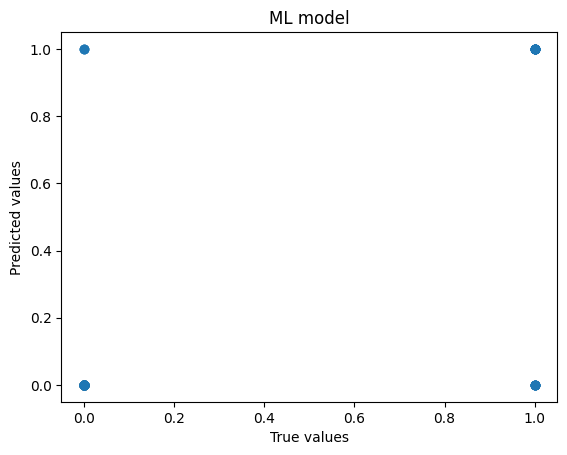

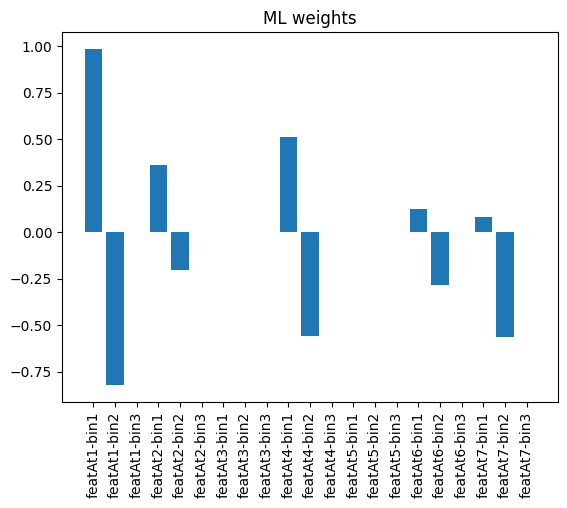

In [75]:
# maximum likelihood (GLM with binomial response and logit link function)
def max_likelihood(X, y):
    logistic = LogisticRegression()
    logistic.solver = 'liblinear'
    logistic.penalty = 'l1'
    weights_ml = get_weights(logistic, X, y)
    print("ML weights:\n", weights_ml)
    
    # plot the model
    plt.figure()
    plt.plot(y, logistic.predict(X), 'o')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('ML model')
    plt.show()

    # plot weights
    plt.figure()
    plt.bar(weights_ml['Feature'], weights_ml['Weight'])
    plt.xticks(rotation=90)
    plt.title('ML weights')
    plt.show()

    return logistic, weights_ml

logistic, app_weights_ml = max_likelihood(disc_app_X, app_y)

SVM weights:
          Feature        Weight
0   featAt1-bin1  2.343750e-01
1   featAt1-bin2 -2.343750e-01
2   featAt1-bin3  0.000000e+00
3   featAt2-bin1  1.718750e-01
4   featAt2-bin2 -1.718750e-01
5   featAt2-bin3  0.000000e+00
6   featAt3-bin1  2.343750e-01
7   featAt3-bin2 -2.343750e-01
8   featAt3-bin3  0.000000e+00
9   featAt4-bin1 -1.387779e-17
10  featAt4-bin2  0.000000e+00
11  featAt4-bin3  0.000000e+00
12  featAt5-bin1  1.562500e-02
13  featAt5-bin2 -1.562500e-02
14  featAt5-bin3  0.000000e+00
15  featAt6-bin1  1.093750e-01
16  featAt6-bin2 -1.093750e-01
17  featAt6-bin3  0.000000e+00
18  featAt7-bin1  2.343750e-01
19  featAt7-bin2 -2.343750e-01
20  featAt7-bin3  0.000000e+00


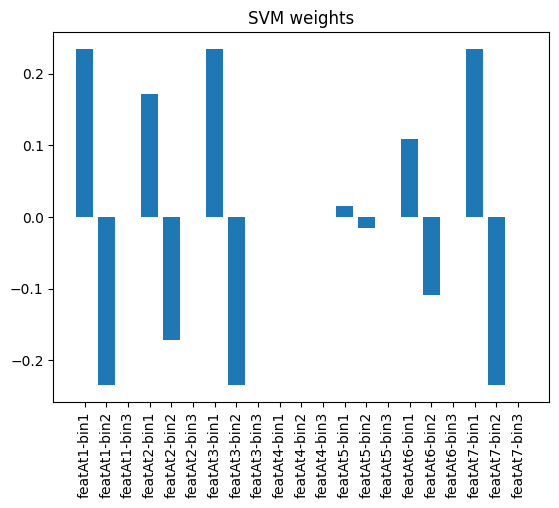

In [76]:
# margin maximization (linear SVM)
def margin_max(X, y):
    param_grid = {
        'C': [2**i for i in range(-10, 11)]
    }
    svm = SVC(kernel='linear')
    #svm = svm_problem(app_y, disc_app_X)
    grid_search_svm = grid_search(svm, X, y, param_grid)
    best_model_svm = grid_search_svm.best_estimator_
    weights_svm = get_weights(best_model_svm, X, y)
    print("SVM weights:\n", weights_svm)

    # plot
    plt.figure()
    plt.bar(weights_svm['Feature'], weights_svm['Weight'])
    plt.xticks(rotation=90)
    plt.title('SVM weights')
    plt.show()

    return best_model_svm, weights_svm

best_model_svm, app_weights_svm = margin_max(disc_app_X, app_y)

ML weights:
            Feature  Weight
0     featAt1-bin1     0.0
1     featAt1-bin2     0.0
2     featAt1-bin3     0.0
3     featAt1-bin4     0.0
4     featAt1-bin5     0.0
..             ...     ...
518  featAt7-bin94     0.0
519  featAt7-bin95     0.0
520  featAt7-bin96     0.0
521  featAt7-bin97     0.0
522  featAt7-bin98     0.0

[523 rows x 2 columns]


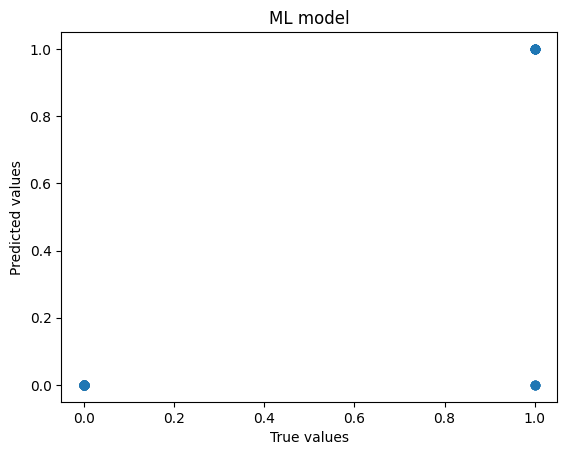

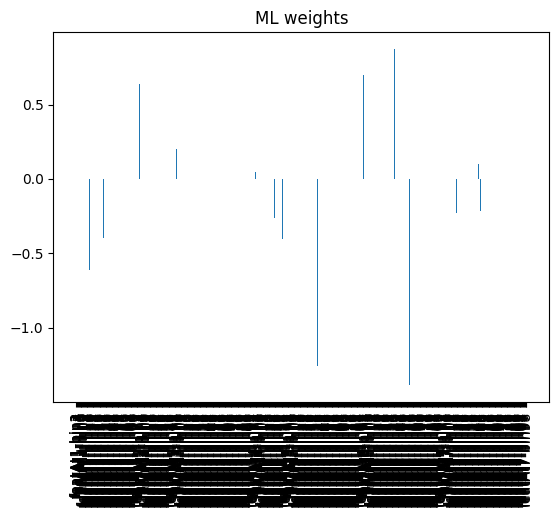

           Feature    Weight
15   featAt1-bin16 -0.613168
31   featAt1-bin32 -0.791694
32   featAt1-bin33 -0.398897
73    featAt2-bin1  0.635908
103  featAt2-bin31 -0.881523
116   featAt3-bin4  0.203830
126  featAt3-bin14 -0.344431
133  featAt3-bin21 -1.029353
208   featAt4-bin2  0.048699
230  featAt4-bin24 -0.261947
239  featAt4-bin33 -0.401207
280  featAt5-bin36 -1.260202
333   featAt6-bin1  0.695462
369  featAt6-bin37  0.872355
386  featAt6-bin54 -1.386040
439  featAt7-bin15 -0.255799
441  featAt7-bin17 -0.227756
466  featAt7-bin42  0.099356
469  featAt7-bin45 -0.214877


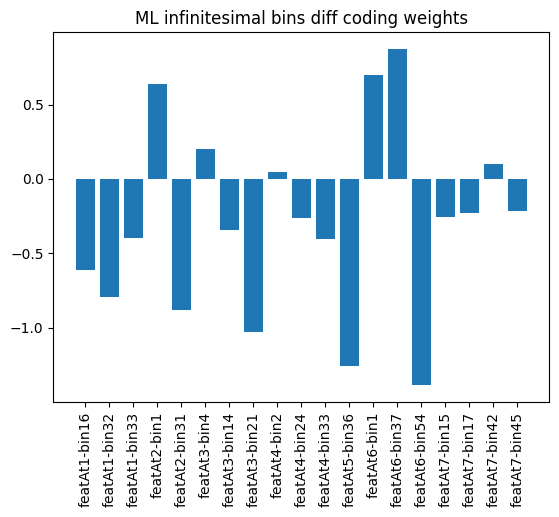

In [77]:
disc_app_X = app_X_disc_infbins_diffcod
ml, app_weights_ml = max_likelihood(disc_app_X, app_y)

# get the weights that are not 0
app_weights = app_weights_ml[app_weights_ml['Weight'] != 0]
print(app_weights)
plt.figure()
plt.bar(app_weights['Feature'], app_weights['Weight'])
plt.xticks(rotation=90)
plt.title('ML infinitesimal bins diff coding weights')
plt.show()

SVM weights:
            Feature    Weight
0     featAt1-bin1 -0.003196
1     featAt1-bin2  0.000710
2     featAt1-bin3 -0.003196
3     featAt1-bin4  0.000710
4     featAt1-bin5 -0.000992
..             ...       ...
518  featAt7-bin94  0.003906
519  featAt7-bin95  0.003906
520  featAt7-bin96  0.003906
521  featAt7-bin97  0.003906
522  featAt7-bin98  0.003906

[523 rows x 2 columns]


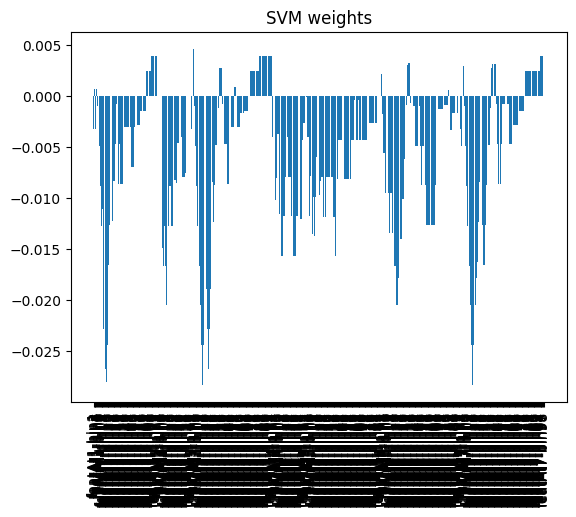

           Feature    Weight
0     featAt1-bin1 -0.003196
1     featAt1-bin2  0.000710
2     featAt1-bin3 -0.003196
3     featAt1-bin4  0.000710
4     featAt1-bin5 -0.000992
..             ...       ...
518  featAt7-bin94  0.003906
519  featAt7-bin95  0.003906
520  featAt7-bin96  0.003906
521  featAt7-bin97  0.003906
522  featAt7-bin98  0.003906

[510 rows x 2 columns]


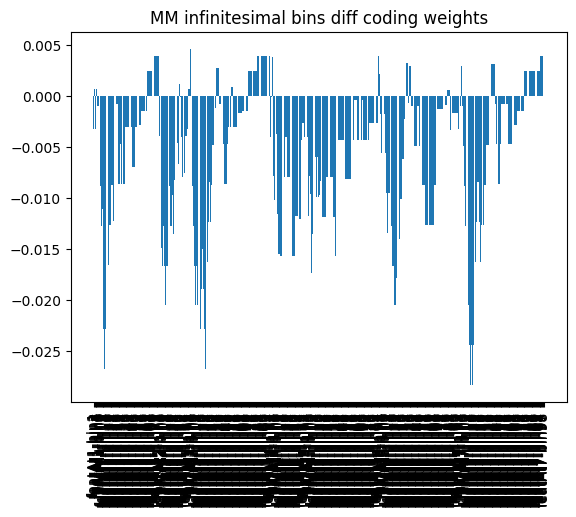

In [78]:
mm, app_weights_mm = margin_max(disc_app_X, app_y)

# get the weights that are not 0
app_weights = app_weights_mm[app_weights_mm['Weight'] != 0]
print(app_weights)
plt.figure()
plt.bar(app_weights['Feature'], app_weights['Weight'])
plt.xticks(rotation=90)
plt.title('MM infinitesimal bins diff coding weights')
plt.show()

#### scorecard

In [79]:
def scorecard(X, y, disc_thresholds_method, disc_version_method, obj_function_method):
    # discretize
    thresholds = disc_thresholds_method(X, X.columns, y)
    disc_X = disc_version_method(X, X.columns, thresholds)
   
    # get weights
    model, weights = obj_function_method(disc_X, y)
    weights2 = weights[weights['Weight'] != 0]
    if weights2.shape[0] < weights.shape[0]:
        print("num of non-zero weights: ", weights2.shape[0])
        print("num of zero weights: ", weights.shape[0] - weights2.shape[0])
        print(weights2)
        plt.figure()
        plt.bar(weights2['Feature'], weights2['Weight'])
        plt.xticks(rotation=90)
        plt.show()

    return model, weights

# app_weights_ml = scorecard(app_X, app_y, discretize_infbins, disc_diff_coding, max_likelihood)

#### evaluation
- accuracy
- sparsity

In [80]:
# CAL = 1/n SUMi SUMi:si=s (pi - ps) 
# where pi is the predicted risk of example i
# ps is the observed risk for all examples with a score of s
def calibration_error(y_test, y_pred):
    unique_scores = np.unique(y_pred)
    n = len(y_test)
    CAL = 0
    for score in unique_scores:
        indices = np.where(y_pred == score)
        si = y_test.iloc[indices]
        ps = si.mean()
        pi = y_pred[indices].mean()
        CAL += len(indices[0]) / n * np.abs(pi - ps)
    return CAL
    

def cross_val_score(model, X, y, n_splits=10):
    kf = KFold(n_splits=n_splits)
    scores = []
    accuracies = []
    AUCs = []
    CALs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(mean_squared_error(y_test, y_pred))
        accuracies.append((y_pred == y_test).mean())
        #AUCs.append(roc_auc_score(y_test, y_pred))
        CALs.append(calibration_error(y_test, y_pred))
        
    print("scores: ", scores)
    print("accuracies: ", accuracies)
    print("AUCs: ", AUCs)
    print("CALs: ", CALs)
    
    print("mean score: ", np.mean(scores))
    print("mean accuracy: ", np.mean(accuracies))
    print("mean AUC: ", np.mean(AUCs))
    print("mean CAL: ", np.mean(CALs))
    return np.mean(scores), np.mean(accuracies), np.mean(AUCs), np.mean(CALs)

RSS best parameters:  {'alpha': 0.001}
RSS weights:
          Feature    Weight
0   featAt1-bin1  0.352374
1   featAt1-bin2  0.352374
2   featAt1-bin3  0.352374
3   featAt2-bin1  0.352374
4   featAt2-bin2  0.352374
5   featAt2-bin3  0.352374
6   featAt3-bin1  0.352374
7   featAt3-bin2  0.352374
8   featAt3-bin3  0.352374
9   featAt4-bin1  0.352374
10  featAt4-bin2  0.352374
11  featAt4-bin3  0.352374
12  featAt5-bin1  0.352374
13  featAt5-bin2  0.352374
14  featAt5-bin3  0.352374
15  featAt6-bin1  0.352374
16  featAt6-bin2  0.352374
17  featAt6-bin3  0.352374
18  featAt7-bin1  0.352374
19  featAt7-bin2  0.352374
20  featAt7-bin3  0.352374


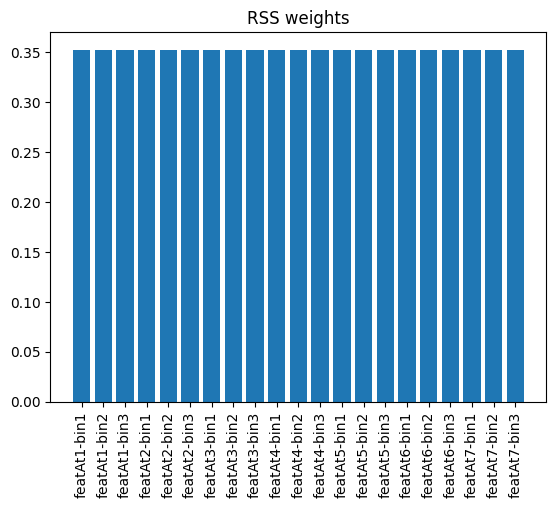

scores:  [0.5098812143024339, 0.42390185498486394, 0.03863462342010107, 0.041184101596382014, 0.052395750051734774, 0.07675825914676707, 0.0042081687239614324, 0.01423255930763831, 0.06371090231457768, 0.15102144227038805]
accuracies:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AUCs:  []
CALs:  [0.6379144178931675, 0.5202816161197958, 0.129010943351394, 0.13921950854900675, 0.14037387582213023, 0.1589106921123272, 0.06487039944351687, 0.09838794137675821, 0.1815831006832327, 0.20324001813908538]
mean score:  0.13759288761188482
mean accuracy:  0.0
mean AUC:  nan
mean CAL:  0.22737925134904144


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [81]:
# CAIM, 1ook, RSS  
rss_model, app_weights = rss(app_X_disc_caim_1outofk, app_y)
scores, acc, AUCs, CALs = cross_val_score(rss_model, app_X_disc_caim_1outofk, app_y)

ML weights:
          Feature    Weight
0   featAt1-bin1  1.310480
1   featAt1-bin2 -0.493446
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.190638
4   featAt2-bin2 -0.374621
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.000000
7   featAt3-bin2  0.000000
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.271253
10  featAt4-bin2 -0.799681
11  featAt4-bin3  0.000000
12  featAt5-bin1  0.000000
13  featAt5-bin2  0.000000
14  featAt5-bin3  0.000000
15  featAt6-bin1  0.295726
16  featAt6-bin2 -0.111988
17  featAt6-bin3  0.000000
18  featAt7-bin1  0.000000
19  featAt7-bin2 -0.649510
20  featAt7-bin3  0.000000


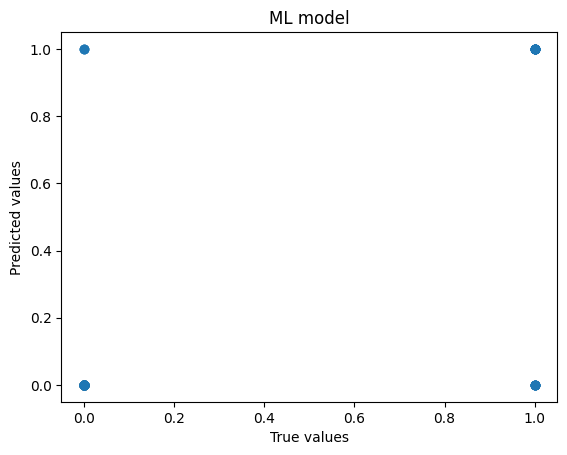

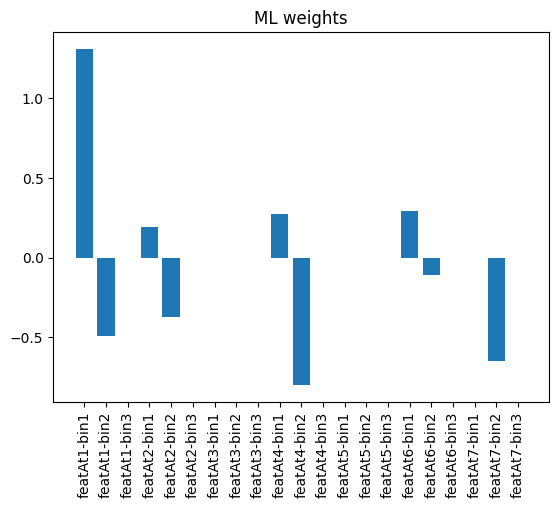

scores:  [0.6363636363636364, 0.45454545454545453, 0.0, 0.0, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.1, 0.1]
accuracies:  [0.36363636363636365, 0.5454545454545454, 1.0, 1.0, 0.9090909090909091, 0.9090909090909091, 1.0, 1.0, 0.9, 0.9]
AUCs:  []
CALs:  [0.6363636363636364, 0.45454545454545453, 0.0, 0.0, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.1, 0.1]
mean score:  0.14727272727272728
mean accuracy:  0.8527272727272728
mean AUC:  nan
mean CAL:  0.14727272727272728


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [82]:
# CAIM, 1ook, ML
ml_model, app_weights = max_likelihood(app_X_disc_caim_1outofk, app_y)
scores, acc, AUCs, CALs = cross_val_score(LogisticRegression(), app_X_disc_caim_1outofk, app_y)

SVM weights:
          Feature        Weight
0   featAt1-bin1  2.343750e-01
1   featAt1-bin2 -2.343750e-01
2   featAt1-bin3  0.000000e+00
3   featAt2-bin1  1.718750e-01
4   featAt2-bin2 -1.718750e-01
5   featAt2-bin3  0.000000e+00
6   featAt3-bin1  2.343750e-01
7   featAt3-bin2 -2.343750e-01
8   featAt3-bin3  0.000000e+00
9   featAt4-bin1 -1.387779e-17
10  featAt4-bin2  0.000000e+00
11  featAt4-bin3  0.000000e+00
12  featAt5-bin1  1.562500e-02
13  featAt5-bin2 -1.562500e-02
14  featAt5-bin3  0.000000e+00
15  featAt6-bin1  1.093750e-01
16  featAt6-bin2 -1.093750e-01
17  featAt6-bin3  0.000000e+00
18  featAt7-bin1  2.343750e-01
19  featAt7-bin2 -2.343750e-01
20  featAt7-bin3  0.000000e+00


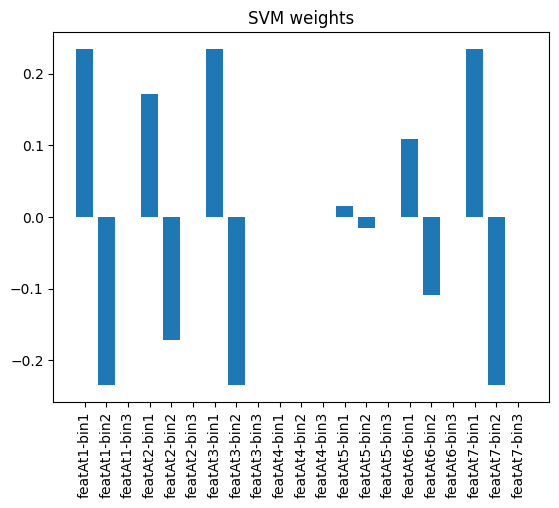

scores:  [0.6363636363636364, 0.45454545454545453, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.1, 0.1]
accuracies:  [0.36363636363636365, 0.5454545454545454, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 1.0, 1.0, 0.9, 0.9]
AUCs:  []
CALs:  [0.6363636363636364, 0.45454545454545453, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.1, 0.1]
mean score:  0.16545454545454547
mean accuracy:  0.8345454545454546
mean AUC:  nan
mean CAL:  0.16545454545454547


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [83]:
# CAIM, 1ook, MM
mm_model, app_weights = margin_max(app_X_disc_caim_1outofk, app_y)
scores, acc, AUCs, CALs = cross_val_score(SVC(kernel='linear'), app_X_disc_caim_1outofk, app_y)

RSS best parameters:  {'alpha': 0.001}
RSS weights:
          Feature  Weight
0   featAt1-bin1     0.0
1   featAt1-bin2     0.0
2   featAt1-bin3     0.0
3   featAt2-bin1     0.0
4   featAt2-bin2     0.0
5   featAt2-bin3     0.0
6   featAt3-bin1     0.0
7   featAt3-bin2     0.0
8   featAt3-bin3     0.0
9   featAt4-bin1     0.0
10  featAt4-bin2     0.0
11  featAt4-bin3     0.0
12  featAt5-bin1     0.0
13  featAt5-bin2     0.0
14  featAt5-bin3     0.0
15  featAt6-bin1     0.0
16  featAt6-bin2     0.0
17  featAt6-bin3     0.0
18  featAt7-bin1     0.0
19  featAt7-bin2     0.0
20  featAt7-bin3     0.0


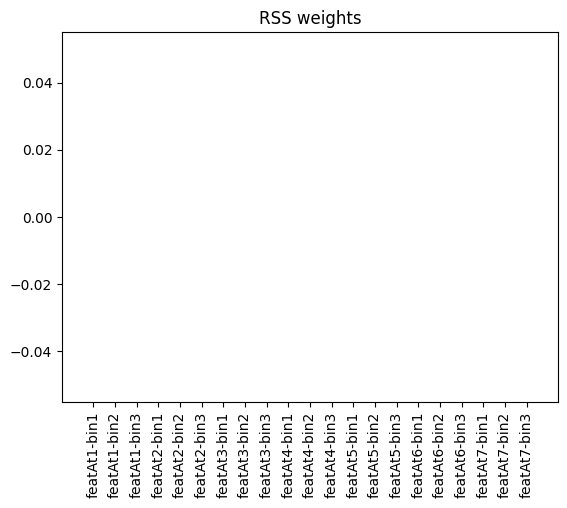

scores:  [0.5098812143024337, 0.42390185498486377, 0.03863462342010096, 0.04118410159638211, 0.05239575005173474, 0.07675825914676654, 0.004208168723961439, 0.014232559307638287, 0.06371090231457763, 0.15102144227038808]
accuracies:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AUCs:  []
CALs:  [0.6379144178931673, 0.5202816161197955, 0.12901094335139385, 0.13921950854900678, 0.1403738758221303, 0.15891069211232675, 0.06487039944351691, 0.09838794137675823, 0.1815831006832327, 0.20324001813908538]
mean score:  0.13759288761188473
mean accuracy:  0.0
mean AUC:  nan
mean CAL:  0.22737925134904136


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [84]:
# CAIM, diff coding, RSS
rss_model, app_weights = rss(app_X_disc_caim_diffcod, app_y)
scores, acc, AUCs, CALs = cross_val_score(rss_model, app_X_disc_caim_diffcod, app_y)

ML weights:
          Feature    Weight
0   featAt1-bin1  0.095790
1   featAt1-bin2 -1.724036
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.015183
4   featAt2-bin2 -0.370861
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.203549
7   featAt3-bin2  0.000000
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.004065
10  featAt4-bin2 -0.738283
11  featAt4-bin3  0.000000
12  featAt5-bin1  0.192907
13  featAt5-bin2  0.000000
14  featAt5-bin3  0.000000
15  featAt6-bin1  0.163370
16  featAt6-bin2 -0.161020
17  featAt6-bin3  0.000000
18  featAt7-bin1  0.306445
19  featAt7-bin2 -0.648003
20  featAt7-bin3  0.000000


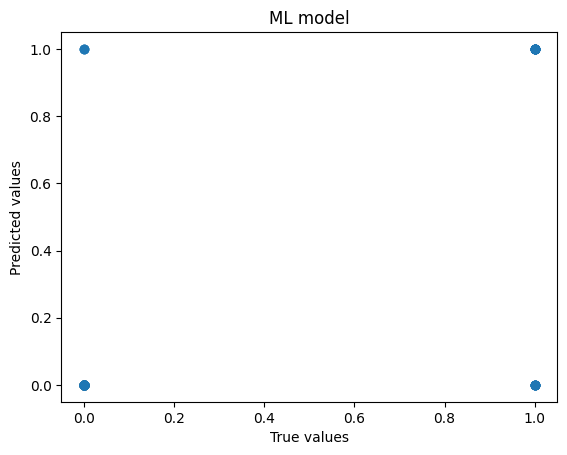

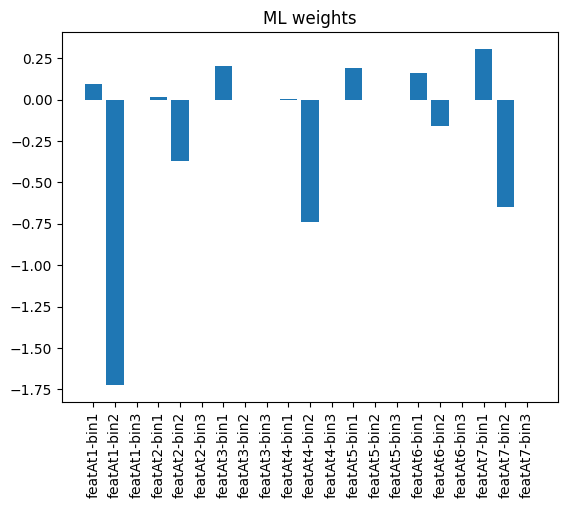

scores:  [0.6363636363636364, 0.45454545454545453, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.1, 0.1]
accuracies:  [0.36363636363636365, 0.5454545454545454, 1.0, 1.0, 0.9090909090909091, 1.0, 1.0, 1.0, 0.9, 0.9]
AUCs:  []
CALs:  [0.6363636363636364, 0.45454545454545453, 0.0, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0, 0.1, 0.1]
mean score:  0.13818181818181818
mean accuracy:  0.8618181818181819
mean AUC:  nan
mean CAL:  0.13818181818181818


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [85]:
# CAIM, diff coding, ML
ml_model, app_weights = max_likelihood(app_X_disc_caim_diffcod, app_y)
scores, acc, AUCs, CALs = cross_val_score(LogisticRegression(), app_X_disc_caim_diffcod, app_y)

SVM weights:
          Feature        Weight
0   featAt1-bin1 -1.110223e-16
1   featAt1-bin2 -4.686650e-01
2   featAt1-bin3  0.000000e+00
3   featAt2-bin1 -1.110223e-16
4   featAt2-bin2 -3.436650e-01
5   featAt2-bin3  0.000000e+00
6   featAt3-bin1 -1.110223e-16
7   featAt3-bin2 -4.686650e-01
8   featAt3-bin3  0.000000e+00
9   featAt4-bin1 -1.110223e-16
10  featAt4-bin2 -5.102041e-04
11  featAt4-bin3  0.000000e+00
12  featAt5-bin1 -1.110223e-16
13  featAt5-bin2 -3.116497e-02
14  featAt5-bin3  0.000000e+00
15  featAt6-bin1 -1.110223e-16
16  featAt6-bin2 -2.186650e-01
17  featAt6-bin3  0.000000e+00
18  featAt7-bin1 -1.110223e-16
19  featAt7-bin2 -4.686650e-01
20  featAt7-bin3  0.000000e+00


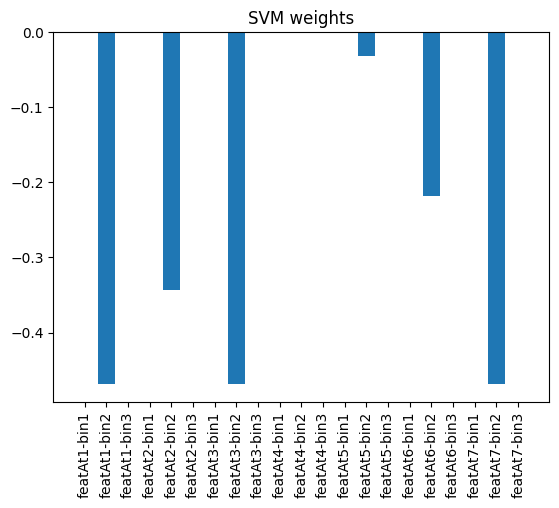

scores:  [0.6363636363636364, 0.45454545454545453, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.1, 0.1]
accuracies:  [0.36363636363636365, 0.5454545454545454, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091, 1.0, 1.0, 0.9, 0.9]
AUCs:  []
CALs:  [0.6363636363636364, 0.45454545454545453, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.1, 0.1]
mean score:  0.16545454545454547
mean accuracy:  0.8345454545454546
mean AUC:  nan
mean CAL:  0.16545454545454547


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [86]:
# CAIM, diff coding, MM
mm_model, app_weights = margin_max(app_X_disc_caim_diffcod, app_y)
scores, acc, AUCs, CALs = cross_val_score(SVC(kernel='linear'), app_X_disc_caim_diffcod, app_y)

RSS best parameters:  {'alpha': 0.001}
RSS weights:
            Feature  Weight
0     featAt1-bin1    -0.0
1     featAt1-bin2    -0.0
2     featAt1-bin3    -0.0
3     featAt1-bin4    -0.0
4     featAt1-bin5    -0.0
..             ...     ...
518  featAt7-bin94    -0.0
519  featAt7-bin95    -0.0
520  featAt7-bin96    -0.0
521  featAt7-bin97    -0.0
522  featAt7-bin98    -0.0

[523 rows x 2 columns]


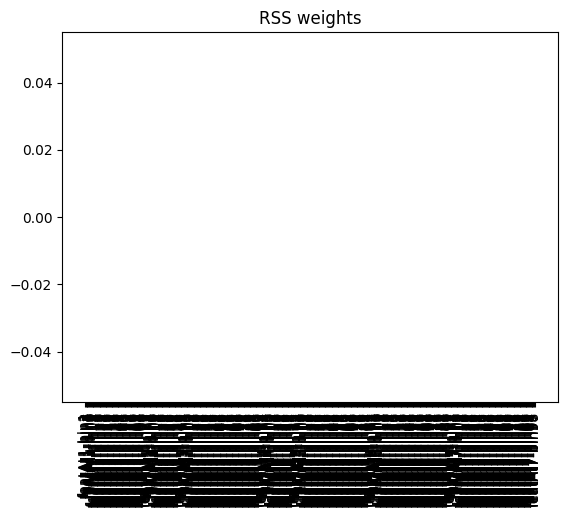

scores:  [0.8023827340690606, 0.6277690041348943, 0.0015981888869702374, 0.0017242148837563135, 0.024453992798946757, 0.00040696624779226385, 0.012231400846282721, 0.06100818525367278, 0.01433332586359189, 0.009416309922677916]
accuracies:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AUCs:  []
CALs:  [0.8186695751900522, 0.6690827123318578, 0.028691001277247982, 0.029993902506313917, 0.08251973204971842, 0.019969696067144396, 0.05787873634224694, 0.09967199781447775, 0.058757755961602834, 0.057818146131601376]
mean score:  0.15553243229076455
mean accuracy:  0.0
mean AUC:  nan
mean CAL:  0.19230532556722638


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [87]:
# infbins, 1ook, RSS
rss_model, app_weights = rss(app_X_disc_infbins_1outofk, app_y)
scores, acc, AUCs, CALs = cross_val_score(rss_model, app_X_disc_infbins_1outofk, app_y)

ML weights:
            Feature  Weight
0     featAt1-bin1     0.0
1     featAt1-bin2     0.0
2     featAt1-bin3     0.0
3     featAt1-bin4     0.0
4     featAt1-bin5     0.0
..             ...     ...
518  featAt7-bin94     0.0
519  featAt7-bin95     0.0
520  featAt7-bin96     0.0
521  featAt7-bin97     0.0
522  featAt7-bin98     0.0

[523 rows x 2 columns]


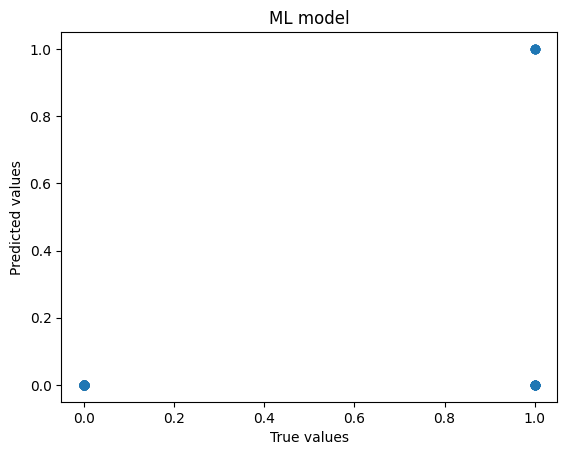

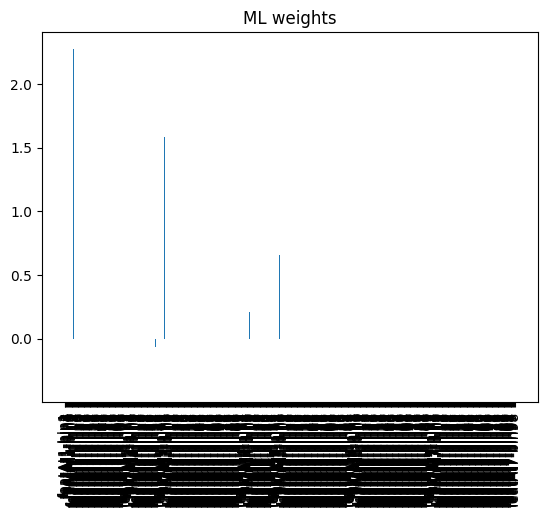

scores:  [1.0, 0.9090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracies:  [0.0, 0.09090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
AUCs:  []
CALs:  [1.0, 0.9090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mean score:  0.19090909090909092
mean accuracy:  0.809090909090909
mean AUC:  nan
mean CAL:  0.19090909090909092


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [88]:
# infbins, 1ook, ML
ml_model, app_weights = max_likelihood(app_X_disc_infbins_1outofk, app_y)
scores, acc, AUCs, CALs = cross_val_score(LogisticRegression(), app_X_disc_infbins_1outofk, app_y)

SVM weights:
            Feature    Weight
0     featAt1-bin1 -0.062627
1     featAt1-bin2  0.313258
2     featAt1-bin3 -0.010897
3     featAt1-bin4  0.222931
4     featAt1-bin5  0.215703
..             ...       ...
518  featAt7-bin94 -0.035483
519  featAt7-bin95 -0.050812
520  featAt7-bin96 -0.063462
521  featAt7-bin97 -0.048621
522  featAt7-bin98  0.278121

[523 rows x 2 columns]


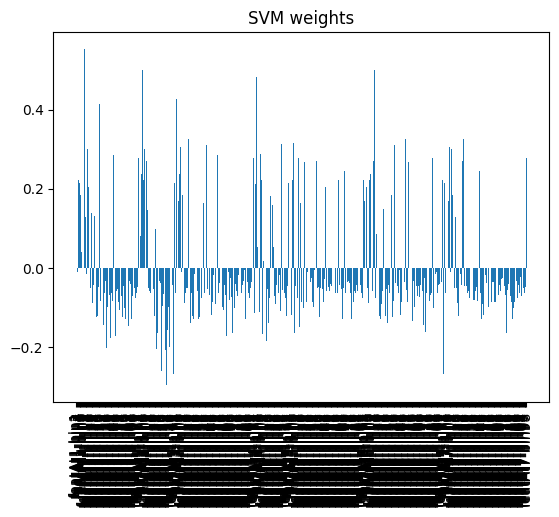

scores:  [0.9090909090909091, 0.9090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]
accuracies:  [0.09090909090909091, 0.09090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9]
AUCs:  []
CALs:  [0.9090909090909091, 0.9090909090909091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]
mean score:  0.19181818181818183
mean accuracy:  0.8081818181818182
mean AUC:  nan
mean CAL:  0.19181818181818183


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [89]:
# infbins, 1ook, MM
mm_model, app_weights = margin_max(app_X_disc_infbins_1outofk, app_y)
scores, acc, AUCs, CALs = cross_val_score(SVC(kernel='linear'), app_X_disc_infbins_1outofk, app_y)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.400e-03, tolerance: 9.726e-04
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.079e-03, tolerance: 1.636e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.364e-02, toleranc

RSS best parameters:  {'alpha': 0.001}
RSS weights:
            Feature  Weight
0     featAt1-bin1    -0.0
1     featAt1-bin2    -0.0
2     featAt1-bin3    -0.0
3     featAt1-bin4    -0.0
4     featAt1-bin5    -0.0
..             ...     ...
518  featAt7-bin94    -0.0
519  featAt7-bin95    -0.0
520  featAt7-bin96    -0.0
521  featAt7-bin97    -0.0
522  featAt7-bin98    -0.0

[523 rows x 2 columns]


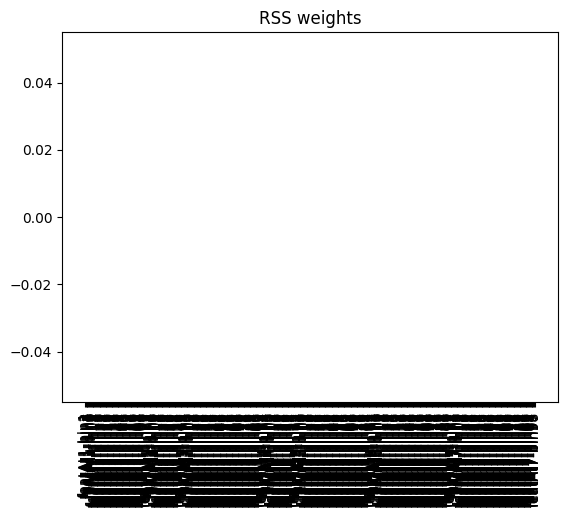

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.400e-03, tolerance: 9.726e-04
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.079e-03, tolerance: 1.636e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.364e-02, toleranc

scores:  [0.7228835273247539, 0.3631999692508511, 0.14550698433278184, 0.055720003768145523, 0.048571768061779645, 0.05663868479289889, 0.035653585119380674, 0.10183523428216139, 0.14236187218449142, 0.13363936558070938]
accuracies:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
AUCs:  []
CALs:  [0.8225655007418614, 0.5333929939161075, 0.2847476364892174, 0.1639925704007174, 0.12487385655358142, 0.17898629720929413, 0.14090803778580785, 0.21765635381506998, 0.26973267654176336, 0.19606564743975408]
mean score:  0.18060109946979538
mean accuracy:  0.0
mean AUC:  nan
mean CAL:  0.2932921570893175


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e-02, tolerance: 1.641e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.417e-03, tolerance: 1.641e-03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.420e-02, toleranc

In [90]:
# infbins, diff coding, RSS
rss_model, app_weights = rss(app_X_disc_infbins_diffcod, app_y)
scores, acc, AUCs, CALs = cross_val_score(rss_model, app_X_disc_infbins_diffcod, app_y)

ML weights:
            Feature  Weight
0     featAt1-bin1     0.0
1     featAt1-bin2     0.0
2     featAt1-bin3     0.0
3     featAt1-bin4     0.0
4     featAt1-bin5     0.0
..             ...     ...
518  featAt7-bin94     0.0
519  featAt7-bin95     0.0
520  featAt7-bin96     0.0
521  featAt7-bin97     0.0
522  featAt7-bin98     0.0

[523 rows x 2 columns]


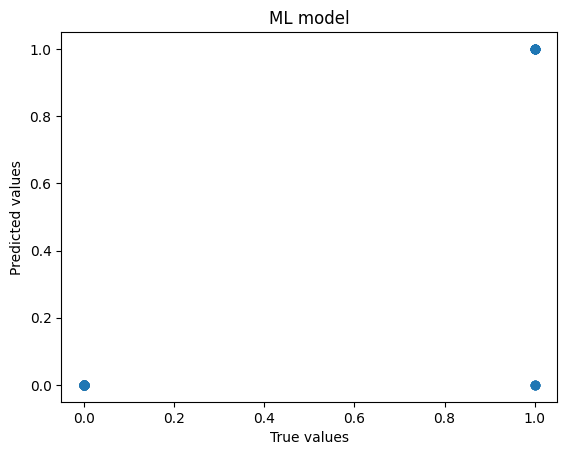

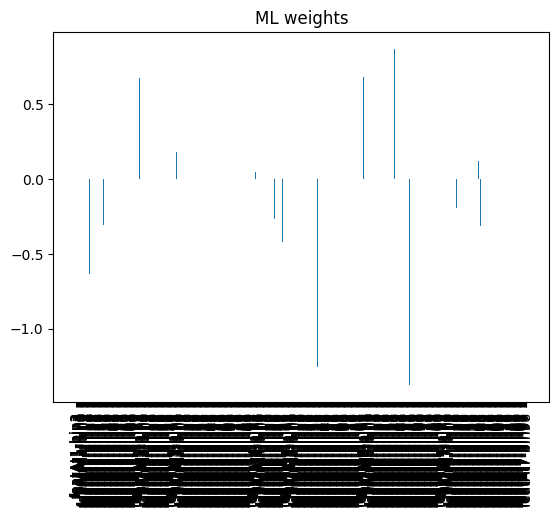

scores:  [0.5454545454545454, 0.45454545454545453, 0.18181818181818182, 0.0, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.2, 0.2]
accuracies:  [0.45454545454545453, 0.5454545454545454, 0.8181818181818182, 1.0, 0.9090909090909091, 0.9090909090909091, 1.0, 1.0, 0.8, 0.8]
AUCs:  []
CALs:  [0.5454545454545454, 0.45454545454545453, 0.18181818181818182, 0.0, 0.09090909090909091, 0.09090909090909091, 0.0, 0.0, 0.2, 0.2]
mean score:  0.17636363636363636
mean accuracy:  0.8236363636363636
mean AUC:  nan
mean CAL:  0.17636363636363636


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [91]:
# infbins, diff coding, ML
ml_model, app_weights = max_likelihood(app_X_disc_infbins_diffcod, app_y)
scores, acc, AUCs, CALs = cross_val_score(LogisticRegression(), app_X_disc_infbins_diffcod, app_y)

SVM weights:
            Feature    Weight
0     featAt1-bin1 -0.003196
1     featAt1-bin2  0.000710
2     featAt1-bin3 -0.003196
3     featAt1-bin4  0.000710
4     featAt1-bin5 -0.000992
..             ...       ...
518  featAt7-bin94  0.003906
519  featAt7-bin95  0.003906
520  featAt7-bin96  0.003906
521  featAt7-bin97  0.003906
522  featAt7-bin98  0.003906

[523 rows x 2 columns]


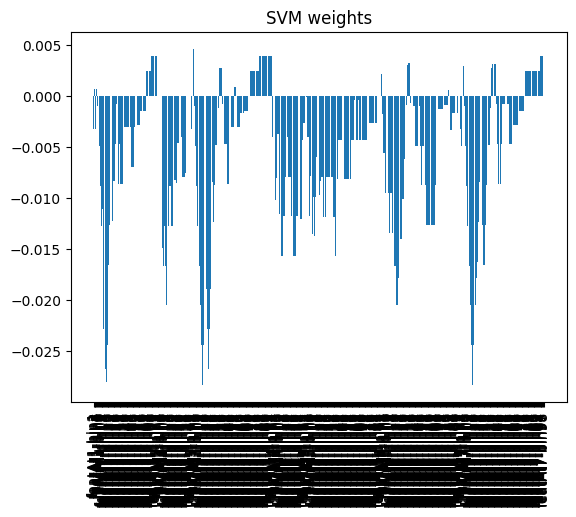

scores:  [0.5454545454545454, 0.5454545454545454, 0.2727272727272727, 0.0, 0.09090909090909091, 0.09090909090909091, 0.1, 0.0, 0.1, 0.2]
accuracies:  [0.45454545454545453, 0.45454545454545453, 0.7272727272727273, 1.0, 0.9090909090909091, 0.9090909090909091, 0.9, 1.0, 0.9, 0.8]
AUCs:  []
CALs:  [0.5454545454545454, 0.5454545454545454, 0.2727272727272727, 0.0, 0.09090909090909091, 0.09090909090909091, 0.1, 0.0, 0.1, 0.2]
mean score:  0.19454545454545455
mean accuracy:  0.8054545454545454
mean AUC:  nan
mean CAL:  0.19454545454545455


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [92]:
# infbins, diff coding, MM
mm_model, app_weights = margin_max(app_X_disc_infbins_diffcod, app_y)
scores, acc, AUCs, CALs = cross_val_score(SVC(kernel='linear'), app_X_disc_infbins_diffcod, app_y)